<a href="https://colab.research.google.com/github/gaixen/RebalanceAI_-241027-/blob/main/Rebalance_AI_Final_DQN_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rebalance-AI Summer Project Final task


*   Training a deep-q-network agent to predict the buy-hold-sell actions




## Importing dependencies

In [44]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym import spaces
import random
from collections import deque, namedtuple
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Fetching the data

In [46]:
def fetch_data(symbols, start_date, end_date):
    """Fetch data for multiple symbols"""
    all_data = []
    for symbol in symbols:
        try:
            df = yf.download(symbol, start=start_date, end=end_date)
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
            df['Symbol'] = symbol
            all_data.append(df)
            print(f"✓ Fetched {len(df)} records for {symbol}")
        except Exception as e:
            print(f"✗ Error fetching {symbol}: {e}")

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n📊 Total combined records: {len(combined_df)}")
        return combined_df.reset_index(drop=True) # Reset index here
    return pd.DataFrame()

def add_indicators(df):
    """Add comprehensive technical indicators to stock DataFrame."""
    import numpy as np
    print("Adding technical indicators...")
    result_dfs = []

    for symbol in df['Symbol'].unique():
        symbol_df = df[df['Symbol'] == symbol].copy()
        print(f"Processing {symbol}...")

        # Moving Averages
        symbol_df['SMA_10'] = symbol_df['Close'].rolling(window=10).mean()
        symbol_df['SMA_20'] = symbol_df['Close'].rolling(window=20).mean()
        symbol_df['EMA_12'] = symbol_df['Close'].ewm(span=12, adjust=False).mean()
        symbol_df['EMA_26'] = symbol_df['Close'].ewm(span=26, adjust=False).mean()

        # RSI
        delta = symbol_df['Close'].diff()
        gain = delta.clip(lower=0).rolling(window=14).mean()
        loss = -delta.clip(upper=0).rolling(window=14).mean()
        rs = gain / (loss + 1e-10)  # avoid divide by zero
        symbol_df['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        symbol_df['MACD'] = symbol_df['EMA_12'] - symbol_df['EMA_26']
        symbol_df['MACD_Signal'] = symbol_df['MACD'].ewm(span=9, adjust=False).mean()
        symbol_df['MACD_Hist'] = symbol_df['MACD'] - symbol_df['MACD_Signal']

        # Bollinger Bands
        sma20 = symbol_df['Close'].rolling(window=20).mean()
        std20 = symbol_df['Close'].rolling(window=20).std()
        symbol_df['BB_Upper'] = sma20 + (2 * std20)
        symbol_df['BB_Lower'] = sma20 - (2 * std20)
        symbol_df['BB_Width'] = (symbol_df['BB_Upper'] - symbol_df['BB_Lower']) / sma20
        symbol_df['BB_Position'] = (symbol_df['Close'] - symbol_df['BB_Lower']) / (symbol_df['BB_Upper'] - symbol_df['BB_Lower'] + 1e-10)

        # ATR (Average True Range)
        high_low = symbol_df['High'] - symbol_df['Low']
        high_close = (symbol_df['High'] - symbol_df['Close'].shift()).abs()
        low_close = (symbol_df['Low'] - symbol_df['Close'].shift()).abs()
        true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        symbol_df['ATR'] = true_range.rolling(window=14).mean()

        # Stochastic Oscillator
        low14 = symbol_df['Low'].rolling(window=14).min()
        high14 = symbol_df['High'].rolling(window=14).max()
        denom = (high14 - low14).replace(0, 1e-10)
        symbol_df['Stoch_K'] = 100 * ((symbol_df['Close'] - low14) / denom)
        symbol_df['Stoch_D'] = symbol_df['Stoch_K'].rolling(window=3).mean()

        # Momentum
        symbol_df['Momentum'] = symbol_df['Close'] / symbol_df['Close'].shift(10) - 1
        symbol_df['ROC'] = symbol_df['Close'].pct_change(10) * 100

        # Volume-based
        symbol_df['Volume_SMA'] = symbol_df['Volume'].rolling(window=20).mean()
        symbol_df['Volume_Ratio'] = symbol_df['Volume'] / (symbol_df['Volume_SMA'] + 1e-10)

        # Price position in recent range
        low_20 = symbol_df['Low'].rolling(window=20).min()
        high_20 = symbol_df['High'].rolling(window=20).max()
        denom_pos = (high_20 - low_20).replace(0, 1e-10)
        symbol_df['Price_Position'] = (symbol_df['Close'] - low_20) / denom_pos

        # Volatility
        symbol_df['Volatility'] = symbol_df['Close'].pct_change().rolling(20).std()

        symbol_df = symbol_df.dropna()
        result_dfs.append(symbol_df)

    final_df = pd.concat(result_dfs, ignore_index=True)
    print(f"final dataset: {len(final_df)} records")
    return final_df


## Environment and agents


In [47]:
class AdvancedTradingEnv(gym.Env):
    """Enhanced Gym environment for multi-stock trading"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200, normalize=True):
        super(AdvancedTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.normalize = normalize
        self.current_symbol = None

        # Shuffle the data
        self.df = self.df.sample(frac=1).reset_index(drop=True)

        # Feature columns
        self.feature_columns = [
            'Close', 'Volume', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26',
            'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Lower',
            'BB_Width', 'BB_Position', 'ATR', 'Stoch_K', 'Stoch_D',
            'Momentum', 'ROC', 'Volume_Ratio', 'Price_Position', 'Volatility'
        ]

        self.original_data = df.copy()
        self.scaler = None
        self.price_scaler = None

        # Normalize features
        if self.normalize:
            self.scaler = StandardScaler()
            self.price_scaler = StandardScaler()
            available_features = [col for col in self.feature_columns if col in df.columns]

            if available_features :
                self.df[available_features] = self.scaler.fit_transform(self.df[available_features])
            else:
                print("No available features for normalization.")

        # Actions: 0 = hold, 1 = buy, 2 = sell
        self.action_space = spaces.Discrete(3)

        # Observation space: features + portfolio state
        n_features = len(self.feature_columns) + 4  # +4 for shares_held, balance, net_worth , current_price
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(n_features,), dtype=np.float32
        )

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        self.previous_net_worth = self.initial_balance
        return self._get_obs()

    def _get_obs(self):
        if self.current_step >= len(self.df):
            self.current_step = len(self.df) - 1

        row = self.df.iloc[self.current_step]

        current_price = self._get_denormalized_price(row['Close'])

        # Get feature values
        features = [row[col] for col in self.feature_columns]

        max_possible_shares = self.initial_balance / max(current_price, 1)

        # Add portfolio state (normalized)
        portfolio_features = [
            self.shares_held / max(max_possible_shares, 1),  # Normalize shares
            (self.balance - self.initial_balance) / self.initial_balance,  # Normalize balance
            (self.net_worth - self.initial_balance) / self.initial_balance,  # Normalize net worth
            min(current_price / self.initial_balance, 1.0)  # Normalize current price
        ]

        obs = np.array(features + portfolio_features, dtype=np.float32)

        obs = np.nan_to_num(obs, nan=0.0, posinf=1.0, neginf=-1.0)

        return obs

    def _get_denormalized_price(self, normalized_price):

        if self.normalize and self.price_scaler is not None:
            try:

                denormalized = self.price_scaler.inverse_transform([[normalized_price]])[0][0]
                return max(denormalized, 0.01)
            except:
                return max(normalized_price, 0.01)
        return max(normalized_price, 0.01)

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, {}

        row = self.df.iloc[self.current_step]
        current_price = self._get_denormalized_price(row['Close'])

        prev_net_worth = self.net_worth
        transaction_cost = 1e-3

        reward = 0

        # Execute action
        if action == 1:  # Buy
            if self.balance >= current_price * (1 + transaction_cost):
                shares_to_buy = int(self.balance / (current_price * (1 + transaction_cost)))
                if shares_to_buy > 0:
                    cost = shares_to_buy * current_price * (1 + transaction_cost)
                    self.shares_held += shares_to_buy
                    self.balance -= cost
                    reward = 0.01  # Small positive reward for successful buy
                else:
                    reward = -0.05
            else:
                reward = -0.05

        elif action == 2:  # Sell
            if self.shares_held > 0:
                revenue = self.shares_held * current_price * (1 - transaction_cost)
                self.balance += revenue
                self.shares_held = 0
                reward = 0.01
            else:
                reward = -0.05  # Penalty for invalid sell

        # Move to next step
        self.current_step += 1
        done = self.current_step >= self.max_steps or self.current_step >= len(self.df) - 1

        if not done and self.current_step < len(self.df):
            next_row = self.df.iloc[self.current_step]
            next_price = self._get_denormalized_price(next_row['Close'])
            self.net_worth = self.balance + self.shares_held * next_price
        else:
            self.net_worth = self.balance + self.shares_held * current_price

        # Calculate reward
        portfolio_change = (self.net_worth - prev_net_worth) / self.initial_balance
        reward += portfolio_change * 10  # Scale portfolio change

        reward = np.clip(reward, -1.0, 1.0)

        info = {
            'net_worth': self.net_worth,
            'balance': self.balance,
            'shares': self.shares_held,
            'current_price': current_price,
            'action': action
        }

        return self._get_obs(), reward, done, info



In [48]:
class ImprovedDQN(nn.Module):
    """Enhanced DQN with Dueling architecture"""
    def __init__(self, input_dim, action_dim, hidden_dim=512):
        super(ImprovedDQN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.2),
        )

        self.value_head = nn.Linear(hidden_dim // 2, 1)
        self.advantage_head = nn.Linear(hidden_dim // 2, action_dim)

    def forward(self, x):
        features = self.feature_extractor(x)

        value = self.value_head(features)
        advantage = self.advantage_head(features)

        # Bellman
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values


In [49]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity=50000, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)

    def push(self, state, action, reward, next_state, done):
        max_prio = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

## Training

### Fetching the data

In [50]:
# symbols = ['META']
symbols = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN', 'NVDA', 'META' , 'NFLX']
print(f"Training symbols: {symbols}")

df = fetch_data(symbols, '2018-01-01', '2023-01-01')

if df.empty:
    print("No data fetched.")
else:
    print(f"symbols: {len(df['Symbol'].unique())} ")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Training symbols: ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN', 'NVDA', 'META', 'NFLX']
✓ Fetched 1259 records for AAPL
✓ Fetched 1259 records for GOOGL
✓ Fetched 1259 records for MSFT
✓ Fetched 1259 records for TSLA
✓ Fetched 1259 records for AMZN



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✓ Fetched 1259 records for NVDA
✓ Fetched 1259 records for META
✓ Fetched 1259 records for NFLX

📊 Total combined records: 10072
symbols: 8 


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10072 entries, 0 to 10071
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Open, AAPL)     1259 non-null   float64
 1   (High, AAPL)     1259 non-null   float64
 2   (Low, AAPL)      1259 non-null   float64
 3   (Close, AAPL)    1259 non-null   float64
 4   (Volume, AAPL)   1259 non-null   float64
 5   (Symbol, )       10072 non-null  object 
 6   (Open, GOOGL)    1259 non-null   float64
 7   (High, GOOGL)    1259 non-null   float64
 8   (Low, GOOGL)     1259 non-null   float64
 9   (Close, GOOGL)   1259 non-null   float64
 10  (Volume, GOOGL)  1259 non-null   float64
 11  (Open, MSFT)     1259 non-null   float64
 12  (High, MSFT)     1259 non-null   float64
 13  (Low, MSFT)      1259 non-null   float64
 14  (Close, MSFT)    1259 non-null   float64
 15  (Volume, MSFT)   1259 non-null   float64
 16  (Open, TSLA)     1259 non-null   float64
 17  (High, TSLA)

### Adding the indicators

In [52]:
def melt_stock_data(df):
    df.columns = pd.MultiIndex.from_tuples([eval(col) if isinstance(col, str) else col for col in df.columns])

    symbols = sorted(set(sym for (_, sym) in df.columns if sym not in (None, '')))
    long_df = []

    for sym in symbols:
        sym_df = df.xs(key=sym, axis=1, level=1).copy()
        sym_df['Symbol'] = sym
        sym_df['Date'] = df.index
        long_df.append(sym_df)

    final_df = pd.concat(long_df, ignore_index=True)
    final_df = final_df[['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return final_df

In [53]:
df_melted = melt_stock_data(df)
df_with_indicators = add_indicators(df_melted)

Adding technical indicators...
Processing AAPL...
Processing AMZN...
Processing GOOGL...
Processing META...
Processing MSFT...
Processing NFLX...
Processing NVDA...
Processing TSLA...
final dataset: 9912 records


In [54]:
print(f"📈 Dataset ready with {len(df_with_indicators.columns)} features")
print(f"Feature columns: {df_with_indicators.columns.tolist()}")
print("Sample of processed data:")
print(df_with_indicators.head())

📈 Dataset ready with 28 features
Feature columns: ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'ATR', 'Stoch_K', 'Stoch_D', 'Momentum', 'ROC', 'Volume_SMA', 'Volume_Ratio', 'Price_Position', 'Volatility']
Sample of processed data:
   Date Symbol       Open       High        Low      Close       Volume  \
0    20   AAPL  39.161878  39.530335  39.075045  39.293301  129915600.0   
1    21   AAPL  39.232277  39.572569  39.136055  39.375435  188923200.0   
2    22   AAPL  38.957694  39.145443  37.573055  37.666927  346375200.0   
3    23   AAPL  37.338362  38.460155  36.610837  36.725834  290954000.0   
4    24   AAPL  36.336269  38.422618  36.141480  38.260685  272975200.0   

      SMA_10     SMA_20     EMA_12  ...  BB_Position       ATR    Stoch_K  \
0  40.623021  40.856885  40.334648  ...     0.046834  0.658962  17.727309   
1  40.353603  

## Training the model

In [55]:
# Training function
def train_multi_stock_dqn(df, episodes=1000, max_steps=300):

    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay = 0.9995
    batch_size = 32
    target_update = 20
    learning_rate = 1e-4

    print(f"Training Configuration:")
    print(f"   Episodes: {episodes}")
    print(f"   Max steps per episode: {max_steps}")
    print(f"   Batch size: {batch_size}")
    print(f"   Learning rate: {learning_rate}")

    # Initialize environment
    env = AdvancedTradingEnv(df, initial_balance=10000, max_steps=max_steps, normalize=True)
    print(f"   Observation space: {env.observation_space.shape}")
    print(f"   Action space: {env.action_space.n}")

    # Initialize networks
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"   Device: {device}")

    policy_net = ImprovedDQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net = ImprovedDQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
    memory = PrioritizedReplayBuffer(capacity=50000)

    # Training loop
    epsilon = epsilon_start
    episode_rewards = []
    episode_net_worths = []
    action_counts = [0, 0, 0]
    best_reward = float('-inf')

    print("Starting training...")

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_actions = []

        for step in range(max_steps):
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.randrange(env.action_space.n)
            else:
                policy_net.eval() # Set policy_net to evaluation mode
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    if len(state_tensor.shape) == 1:
                        state_tensor = state_tensor.unsqueeze(0)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()
                policy_net.train() # Set policy_net back to training mode


            next_state, reward, done, info = env.step(action)
            if np.any(np.isnan(state)) or np.any(np.isnan(next_state)):
                continue
            memory.push(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            episode_actions.append(action)
            action_counts[action] += 1

            # Training
            if len(memory) >= batch_size*2:
                samples, indices, weights = memory.sample(batch_size)

                states = torch.FloatTensor([s[0] for s in samples]).to(device)
                actions = torch.LongTensor([s[1] for s in samples]).to(device)
                rewards = torch.FloatTensor([s[2] for s in samples]).to(device)
                next_states = torch.FloatTensor([s[3] for s in samples]).to(device)
                dones = torch.BoolTensor([s[4] for s in samples]).to(device)
                weights_tensor = torch.FloatTensor(weights).to(device)

                current_q_values = policy_net(states).gather(1, actions.unsqueeze(1))
                next_q_values = target_net(next_states).max(1)[0].detach()
                target_q_values = rewards + (gamma * next_q_values * ~dones)

                # Compute loss with importance sampling weights
                td_errors = current_q_values.squeeze() - target_q_values
                loss = (weights_tensor * td_errors.pow(2)).mean()

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()

                # Update priorities
                priorities = np.abs(td_errors.detach().cpu().numpy()) + 1e-6
                memory.update_priorities(indices, priorities)

            if done:
                break

        # Update target network
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decay epsilon and update scheduler
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        scheduler.step()

        # Track performance
        episode_rewards.append(total_reward)
        episode_net_worths.append(info.get('net_worth', env.initial_balance))

        # Save best model

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), 'best_dqn_model.pth')

        # Progress reporting
        if episode % 25 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_net_worth = np.mean(episode_net_worths[-50:])
            action_dist = [c/sum(action_counts)*100 for c in action_counts]
            print(f"Episode {episode:4d}/{episodes} | "
                  f"Avg Reward: {avg_reward:8.2f} | "
                  f"Avg Net Worth: ${avg_net_worth:8.2f} | "
                  f"Epsilon: {epsilon:.3f} | "
                  f"Actions: H{action_dist[0]:.1f}% B{action_dist[1]:.1f}% S{action_dist[2]:.1f}%")

    print("Training completed!")
    print(f"Final action distribution: Hold {action_counts[0]}, Buy {action_counts[1]}, Sell {action_counts[2]}")
    return policy_net, env, episode_rewards, episode_net_worths

In [56]:
def debug_environment(df, initial_balance=10000, max_steps=10):
    """Debug the environment to understand action behavior"""
    env = AdvancedTradingEnv(df, initial_balance=initial_balance, max_steps=max_steps, normalize=True)

    print("=== ENVIRONMENT DEBUG ===")
    print(f"Initial balance: ${initial_balance}")
    print(f"Data shape: {df.shape}")
    print(f"Max steps: {max_steps}")

    state = env.reset()
    print(f"Initial state shape: {state.shape}")
    print(f"Initial state: {state}")
    print(f"Initial net worth: ${env.net_worth}")
    print(f"Initial balance: ${env.balance}")
    print(f"Initial shares: {env.shares_held}")

    for step in range(min(5, max_steps)):
        for action in range(3):
            # Save state
            saved_balance = env.balance
            saved_shares = env.shares_held
            saved_step = env.current_step

            # Try action
            next_state, reward, done, info = env.step(action)

            print(f"\nStep {step}, Action {action} ({'Hold' if action==0 else 'Buy' if action==1 else 'Sell'}):")
            print(f"  Reward: {reward:.4f}")
            print(f"  Net worth: ${info['net_worth']:.2f}")
            print(f"  Balance: ${info['balance']:.2f}")
            print(f"  Shares: {info['shares']}")
            print(f"  Price: ${info['current_price']:.2f}")
            print(f"  Done: {done}")

            # Reset state for next action test
            env.balance = saved_balance
            env.shares_held = saved_shares
            env.current_step = saved_step

        # Actually take hold action to advance
        env.step(0)
        if done:
            break

In [57]:
debug_environment(df_with_indicators, initial_balance=10000, max_steps=10)

=== ENVIRONMENT DEBUG ===
Initial balance: $10000
Data shape: (9912, 28)
Max steps: 10
Initial state shape: (26,)
Initial state: [ 2.1599650e+00 -5.3564858e-01  1.9662360e+00  1.7979493e+00
  1.9686998e+00  1.8149463e+00  9.1031551e-01  3.3941066e+00
  2.4153233e+00  3.8685820e+00  2.0112560e+00  1.5335238e+00
  1.3653415e+00  1.0145837e+00  2.6746974e+00  8.6907524e-01
  8.4252995e-01  1.5732796e+00  1.5732796e+00  2.9367256e+00
  9.4243973e-01  6.7968422e-01  0.0000000e+00  0.0000000e+00
  0.0000000e+00  2.1599649e-04]
Initial net worth: $10000.0
Initial balance: $10000.0
Initial shares: 0

Step 0, Action 0 (Hold):
  Reward: 0.0000
  Net worth: $10000.00
  Balance: $10000.00
  Shares: 0
  Price: $2.16
  Done: False

Step 0, Action 1 (Buy):
  Reward: -1.0000
  Net worth: $249.06
  Balance: $0.17
  Shares: 4625
  Price: $2.16
  Done: False

Step 0, Action 2 (Sell):
  Reward: 1.0000
  Net worth: $10000.00
  Balance: $10000.00
  Shares: 0
  Price: $2.16
  Done: False

Step 1, Action 0 (H

In [58]:
trained_model, trained_env, training_rewards, training_net_worths = train_multi_stock_dqn(
    df_with_indicators,
    episodes=500,
    max_steps=50
)

Training Configuration:
   Episodes: 500
   Max steps per episode: 50
   Batch size: 32
   Learning rate: 0.0001
   Observation space: (26,)
   Action space: 3
   Device: cuda
Starting training...
Episode    0/500 | Avg Reward:    -0.69 | Avg Net Worth: $45148.09 | Epsilon: 1.000 | Actions: H34.0% B32.0% S34.0%
Episode   25/500 | Avg Reward:    -1.57 | Avg Net Worth: $291112810180.47 | Epsilon: 0.987 | Actions: H33.2% B33.0% S33.8%
Episode   50/500 | Avg Reward:    -1.46 | Avg Net Worth: $151437475466.00 | Epsilon: 0.975 | Actions: H33.0% B32.7% S34.4%
Episode   75/500 | Avg Reward:    -1.27 | Avg Net Worth: $9029133320.90 | Epsilon: 0.963 | Actions: H33.9% B32.3% S33.8%
Episode  100/500 | Avg Reward:    -1.20 | Avg Net Worth: $9668672314.23 | Epsilon: 0.951 | Actions: H33.1% B32.9% S34.0%
Episode  125/500 | Avg Reward:    -1.21 | Avg Net Worth: $6865378157.42 | Epsilon: 0.939 | Actions: H32.8% B33.2% S34.0%
Episode  150/500 | Avg Reward:    -1.19 | Avg Net Worth: $77442223847.59 | Eps

## Evaluation

In [59]:
def evaluate_model(policy_net, test_symbols, start_date, end_date , initial_balance = 10000 , max_steps = 200):
    # Fetch test data
    test_df = fetch_data(test_symbols, start_date, end_date)
    test_df = melt_stock_data(test_df)
    test_df = add_indicators(test_df)

    if initial_balance <= 0:
        initial_balance = 10000
        print("initial_balance value reset to 10,000")

    # Create test environment
    test_env = AdvancedTradingEnv(test_df, initial_balance=10000, max_steps=200, normalize=True)

    # Test the trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    policy_net.to(device)
    state = test_env.reset()
    dqn_values = [test_env.initial_balance]
    actions_taken = []
    prices = []

    policy_net.eval()
    with torch.no_grad():
        for step in range(min(max_steps, len(test_df) - 1)):
            try:

                state_tensor = torch.FloatTensor(state).to(device)
                if len(state_tensor.shape) == 1:
                    state_tensor = state_tensor.unsqueeze(0)
                q_values = policy_net(state_tensor)

                # Use epsilon-greedy algorithm
                if random.random() < 0.1:  # 10% random actions
                    action = random.randrange(test_env.action_space.n)
                else:
                    action = q_values.argmax().item()

                next_state, reward, done, info = test_env.step(action)

                if np.any(np.isnan(next_state)):
                    print(f"Warning: NaN detected in state at step {step}")
                    break

                state = next_state
                dqn_values.append(info['net_worth'])
                actions_taken.append(action)
                prices.append(info['current_price'])

                if step % 50 == 0:
                    print(f"Step {step}: Action={action}, Price=${info['current_price']:.2f}, "
                          f"Net Worth=${info['net_worth']:.2f}, Balance=${info['balance']:.2f}, "
                          f"Shares={info['shares']}")

                if done:
                    break

            except Exception as e:
                print(f"Error at step {step}: {e}")
                break

    # Calculate buy-and-hold baseline
    if prices:
        initial_price = prices[0]
        shares_bh = initial_balance / initial_price
        buy_hold_values = [shares_bh * price for price in prices]
        # Align lengths
        min_len = min(len(dqn_values), len(buy_hold_values))
        dqn_values = dqn_values[:min_len]
        buy_hold_values = buy_hold_values[:min_len]
    else:
        buy_hold_values = [initial_balance] * len(dqn_values)

    print(f"evaluation completed on {len(dqn_values)} time steps")
    print(f"Action distribution: Hold {actions_taken.count(0)}, Buy {actions_taken.count(1)}, Sell {actions_taken.count(2)}")

    return dqn_values, buy_hold_values, actions_taken

In [60]:
# Evaluate on test data
test_symbols = ['AAPL', 'GOOGL', 'MSFT']  # Subset for testing
dqn_values, buy_hold_values, actions = evaluate_model(
    trained_model, test_symbols, '2022-01-01', '2023-01-01' , initial_balance = 0 , max_steps = 500
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✓ Fetched 251 records for AAPL
✓ Fetched 251 records for GOOGL
✓ Fetched 251 records for MSFT

📊 Total combined records: 753
Adding technical indicators...
Processing AAPL...
Processing GOOGL...
Processing MSFT...
final dataset: 693 records
initial_balance value reset to 10,000
Step 0: Action=1, Price=$0.01, Net Worth=$1528941.34, Balance=$0.01, Shares=999000


Step 50: Action=2, Price=$0.01, Net Worth=$275395963.91, Balance=$275395963.91, Shares=0
Step 100: Action=2, Price=$1.14, Net Worth=$275395963.91, Balance=$275395963.91, Shares=0
Step 150: Action=1, Price=$0.01, Net Worth=$6878.03, Balance=$0.01, Shares=6888
evaluation completed on 200 time steps
Action distribution: Hold 3, Buy 67, Sell 130


### Plotting the results

In [66]:
def plot_results(dqn_values, buy_hold_values, actions, prices=None):
    """Enhanced plotting with comprehensive analysis"""

    # Create a more comprehensive figure layout
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    # Main portfolio comparison (top row, spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    time_steps = range(len(dqn_values))

    # Portfolio value comparison with fill between
    ax1.plot(time_steps, dqn_values, label='DQN Agent', linewidth=2.5, color='#2E86AB')
    ax1.plot(time_steps, buy_hold_values, label='Buy & Hold', linewidth=2.5, color='#A23B72')
    ax1.fill_between(time_steps, dqn_values, buy_hold_values,
                     where=np.array(dqn_values) >= np.array(buy_hold_values),
                     alpha=0.3, color='#2E86AB', label='DQN Outperformance')
    ax1.fill_between(time_steps, dqn_values, buy_hold_values,
                     where=np.array(dqn_values) < np.array(buy_hold_values),
                     alpha=0.3, color='#A23B72', label='B&H Outperformance')
    ax1.set_title('Portfolio Value Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Cumulative returns (top row, right side)
    ax2 = fig.add_subplot(gs[0, 2:])
    if len(dqn_values) > 1 and len(buy_hold_values) > 1:
        dqn_returns = [(val - dqn_values[0]) / dqn_values[0] * 100 for val in dqn_values]
        bh_returns = [(val - buy_hold_values[0]) / buy_hold_values[0] * 100 for val in buy_hold_values]

        ax2.plot(time_steps, dqn_returns, label='DQN Agent', linewidth=2.5, color='#2E86AB')
        ax2.plot(time_steps, bh_returns, label='Buy & Hold', linewidth=2.5, color='#A23B72')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_title('Cumulative Returns (%)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Time Steps')
        ax2.set_ylabel('Return (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # Action distribution pie chart
    ax3 = fig.add_subplot(gs[1, 0])
    action_names = ['Hold', 'Buy', 'Sell']
    action_counts = [actions.count(i) for i in range(3)]
    colors = ['#F18F01', '#C73E1D', '#2E86AB']

    if sum(action_counts) == 0:
        action_counts = [1, 1, 1]

    wedges, texts, autotexts = ax3.pie(action_counts, labels=action_names, autopct='%1.1f%%',
                                       colors=colors, startangle=90)
    ax3.set_title('Action Distribution', fontsize=12, fontweight='bold')

    # Action frequency heatmap
    ax4 = fig.add_subplot(gs[1, 1])
    if actions:
        # Create action frequency over time windows
        window_size = max(1, len(actions) // 20)
        action_windows = []
        for i in range(0, len(actions), window_size):
            window = actions[i:i+window_size]
            window_counts = [window.count(j) for j in range(3)]
            action_windows.append(window_counts)

        if action_windows:
            action_matrix = np.array(action_windows).T
            im = ax4.imshow(action_matrix, cmap='YlOrRd', aspect='auto')
            ax4.set_title('Action Frequency Over Time', fontsize=12, fontweight='bold')
            ax4.set_ylabel('Action Type')
            ax4.set_xlabel('Time Windows')
            ax4.set_yticks([0, 1, 2])
            ax4.set_yticklabels(['Hold', 'Buy', 'Sell'])
            plt.colorbar(im, ax=ax4, shrink=0.8)

    # Actions over time with enhanced visualization
    ax5 = fig.add_subplot(gs[1, 2:])
    if actions:
        # Color-coded action timeline
        colors_map = {0: '#F18F01', 1: '#C73E1D', 2: '#2E86AB'}
        colors_list = [colors_map[action] for action in actions]

        ax5.scatter(range(len(actions)), actions, c=colors_list, alpha=0.7, s=20)
        ax5.set_title('Actions Over Time', fontsize=12, fontweight='bold')
        ax5.set_xlabel('Time Steps')
        ax5.set_ylabel('Action')
        ax5.set_yticks([0, 1, 2])
        ax5.set_yticklabels(['Hold', 'Buy', 'Sell'])
        ax5.grid(True, alpha=0.3)

        # Add action change markers
        action_changes = [i for i in range(1, len(actions)) if actions[i] != actions[i-1]]
        if action_changes:
            for change_point in action_changes:
                ax5.axvline(x=change_point, color='red', alpha=0.3, linestyle='--', linewidth=0.5)

    # Performance metrics comparison
    ax6 = fig.add_subplot(gs[2, :2])
    if len(dqn_values) > 1 and len(buy_hold_values) > 1:
        dqn_return = (dqn_values[-1] - dqn_values[0]) / dqn_values[0] * 100
        bh_return = (buy_hold_values[-1] - buy_hold_values[0]) / buy_hold_values[0] * 100

        # Calculate additional metrics
        dqn_volatility = np.std(np.diff(dqn_values) / dqn_values[:-1]) * 100
        bh_volatility = np.std(np.diff(buy_hold_values) / buy_hold_values[:-1]) * 100

        dqn_sharpe = dqn_return / dqn_volatility if dqn_volatility != 0 else 0
        bh_sharpe = bh_return / bh_volatility if bh_volatility != 0 else 0

        max_dqn = max(dqn_values)
        max_drawdown_dqn = (max_dqn - min(dqn_values[dqn_values.index(max_dqn):])) / max_dqn * 100

        max_bh = max(buy_hold_values)
        max_drawdown_bh = (max_bh - min(buy_hold_values[buy_hold_values.index(max_bh):])) / max_bh * 100

        metrics = ['Total Return (%)', 'Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)']
        dqn_metrics = [dqn_return, dqn_volatility, dqn_sharpe, max_drawdown_dqn]
        bh_metrics = [bh_return, bh_volatility, bh_sharpe, max_drawdown_bh]

        x = np.arange(len(metrics))
        width = 0.35

        bars1 = ax6.bar(x - width/2, dqn_metrics, width, label='DQN Agent', alpha=0.8, color='#2E86AB')
        bars2 = ax6.bar(x + width/2, bh_metrics, width, label='Buy & Hold', alpha=0.8, color='#A23B72')

        ax6.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
        ax6.set_xticks(x)
        ax6.set_xticklabels(metrics, rotation=45, ha='right')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
        for bar in bars2:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    # Rolling performance comparison
    ax7 = fig.add_subplot(gs[2, 2:])
    if len(dqn_values) > 10:
        window = min(20, len(dqn_values) // 4)
        dqn_rolling_return = pd.Series(dqn_values).pct_change().rolling(window).mean() * 100
        bh_rolling_return = pd.Series(buy_hold_values).pct_change().rolling(window).mean() * 100

        ax7.plot(dqn_rolling_return.index, dqn_rolling_return.values,
                label=f'DQN Rolling Return ({window})', linewidth=2, color='#2E86AB')
        ax7.plot(bh_rolling_return.index, bh_rolling_return.values,
                label=f'B&H Rolling Return ({window})', linewidth=2, color='#A23B72')
        ax7.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax7.set_title('Rolling Performance', fontsize=12, fontweight='bold')
        ax7.set_xlabel('Time Steps')
        ax7.set_ylabel('Rolling Return (%)')
        ax7.legend()
        ax7.grid(True, alpha=0.3)

    # Portfolio allocation over time
    ax8 = fig.add_subplot(gs[3, :2])
    if hasattr(ax8, 'twinx'):  # Check if we can create twin axis
        # This would require tracking cash vs stock allocation over time
        # For now, show a simple cash vs investment ratio
        ax8.text(0.5, 0.5, 'Portfolio Allocation\n(Requires additional tracking)',
                ha='center', va='center', transform=ax8.transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax8.set_title('Portfolio Allocation Over Time', fontsize=12, fontweight='bold')

    # Risk-Return scatter plot
    ax9 = fig.add_subplot(gs[3, 2:])
    if len(dqn_values) > 1 and len(buy_hold_values) > 1:
        # Calculate risk-return for different time windows
        window_size = max(5, len(dqn_values) // 10)
        dqn_risk_return = []
        bh_risk_return = []

        for i in range(window_size, len(dqn_values), window_size):
            window_dqn = dqn_values[i-window_size:i]
            window_bh = buy_hold_values[i-window_size:i]

            dqn_ret = (window_dqn[-1] - window_dqn[0]) / window_dqn[0] * 100
            bh_ret = (window_bh[-1] - window_bh[0]) / window_bh[0] * 100

            dqn_risk = np.std(np.diff(window_dqn) / window_dqn[:-1]) * 100
            bh_risk = np.std(np.diff(window_bh) / window_bh[:-1]) * 100

            dqn_risk_return.append((dqn_risk, dqn_ret))
            bh_risk_return.append((bh_risk, bh_ret))

        if dqn_risk_return and bh_risk_return:
            dqn_risks, dqn_rets = zip(*dqn_risk_return)
            bh_risks, bh_rets = zip(*bh_risk_return)

            ax9.scatter(dqn_risks, dqn_rets, alpha=0.7, s=60, color='#2E86AB', label='DQN Agent')
            ax9.scatter(bh_risks, bh_rets, alpha=0.7, s=60, color='#A23B72', label='Buy & Hold')
            ax9.set_xlabel('Risk (Volatility %)')
            ax9.set_ylabel('Return (%)')
            ax9.set_title('Risk-Return Scatter', fontsize=12, fontweight='bold')
            ax9.legend()
            ax9.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Enhanced summary report
    if len(dqn_values) > 1 and len(buy_hold_values) > 1:
        print(f"\n{'='*70}")
        print("📊 COMPREHENSIVE PERFORMANCE ANALYSIS")
        print(f"{'='*70}")

        dqn_return = (dqn_values[-1] - dqn_values[0]) / dqn_values[0] * 100
        bh_return = (buy_hold_values[-1] - buy_hold_values[0]) / buy_hold_values[0] * 100

        print(f"💰 RETURNS:")
        print(f"   DQN Agent Return:     {dqn_return:8.2f}%")
        print(f"   Buy & Hold Return:    {bh_return:8.2f}%")
        print(f"   📈 Outperformance:    {dqn_return - bh_return:8.2f}%")

        print(f"\n💼 PORTFOLIO VALUES:")
        print(f"   Initial Value:        ${dqn_values[0]:,.2f}")
        print(f"   Final DQN Value:      ${dqn_values[-1]:,.2f}")
        print(f"   Final B&H Value:      ${buy_hold_values[-1]:,.2f}")

        print(f"\n📊 RISK METRICS:")
        dqn_volatility = np.std(np.diff(dqn_values) / dqn_values[:-1]) * 100
        bh_volatility = np.std(np.diff(buy_hold_values) / buy_hold_values[:-1]) * 100
        print(f"   DQN Volatility:       {dqn_volatility:8.2f}%")
        print(f"   B&H Volatility:       {bh_volatility:8.2f}%")

        dqn_sharpe = dqn_return / dqn_volatility if dqn_volatility != 0 else 0
        bh_sharpe = bh_return / bh_volatility if bh_volatility != 0 else 0
        print(f"   DQN Sharpe Ratio:     {dqn_sharpe:8.2f}")
        print(f"   B&H Sharpe Ratio:     {bh_sharpe:8.2f}")

        print(f"\n🎯 TRADING ACTIVITY:")
        action_counts = [actions.count(i) for i in range(3)]
        total_actions = sum(action_counts)
        print(f"   Total Actions:        {total_actions}")
        print(f"   Hold Actions:         {action_counts[0]:4d} ({action_counts[0]/total_actions*100:.1f}%)")
        print(f"   Buy Actions:          {action_counts[1]:4d} ({action_counts[1]/total_actions*100:.1f}%)")
        print(f"   Sell Actions:         {action_counts[2]:4d} ({action_counts[2]/total_actions*100:.1f}%)")

        # Action efficiency
        if action_counts[1] > 0 or action_counts[2] > 0:
            active_actions = action_counts[1] + action_counts[2]
            print(f"   Active Trading:       {active_actions:4d} ({active_actions/total_actions*100:.1f}%)")

        print(f"\n{'='*70}")

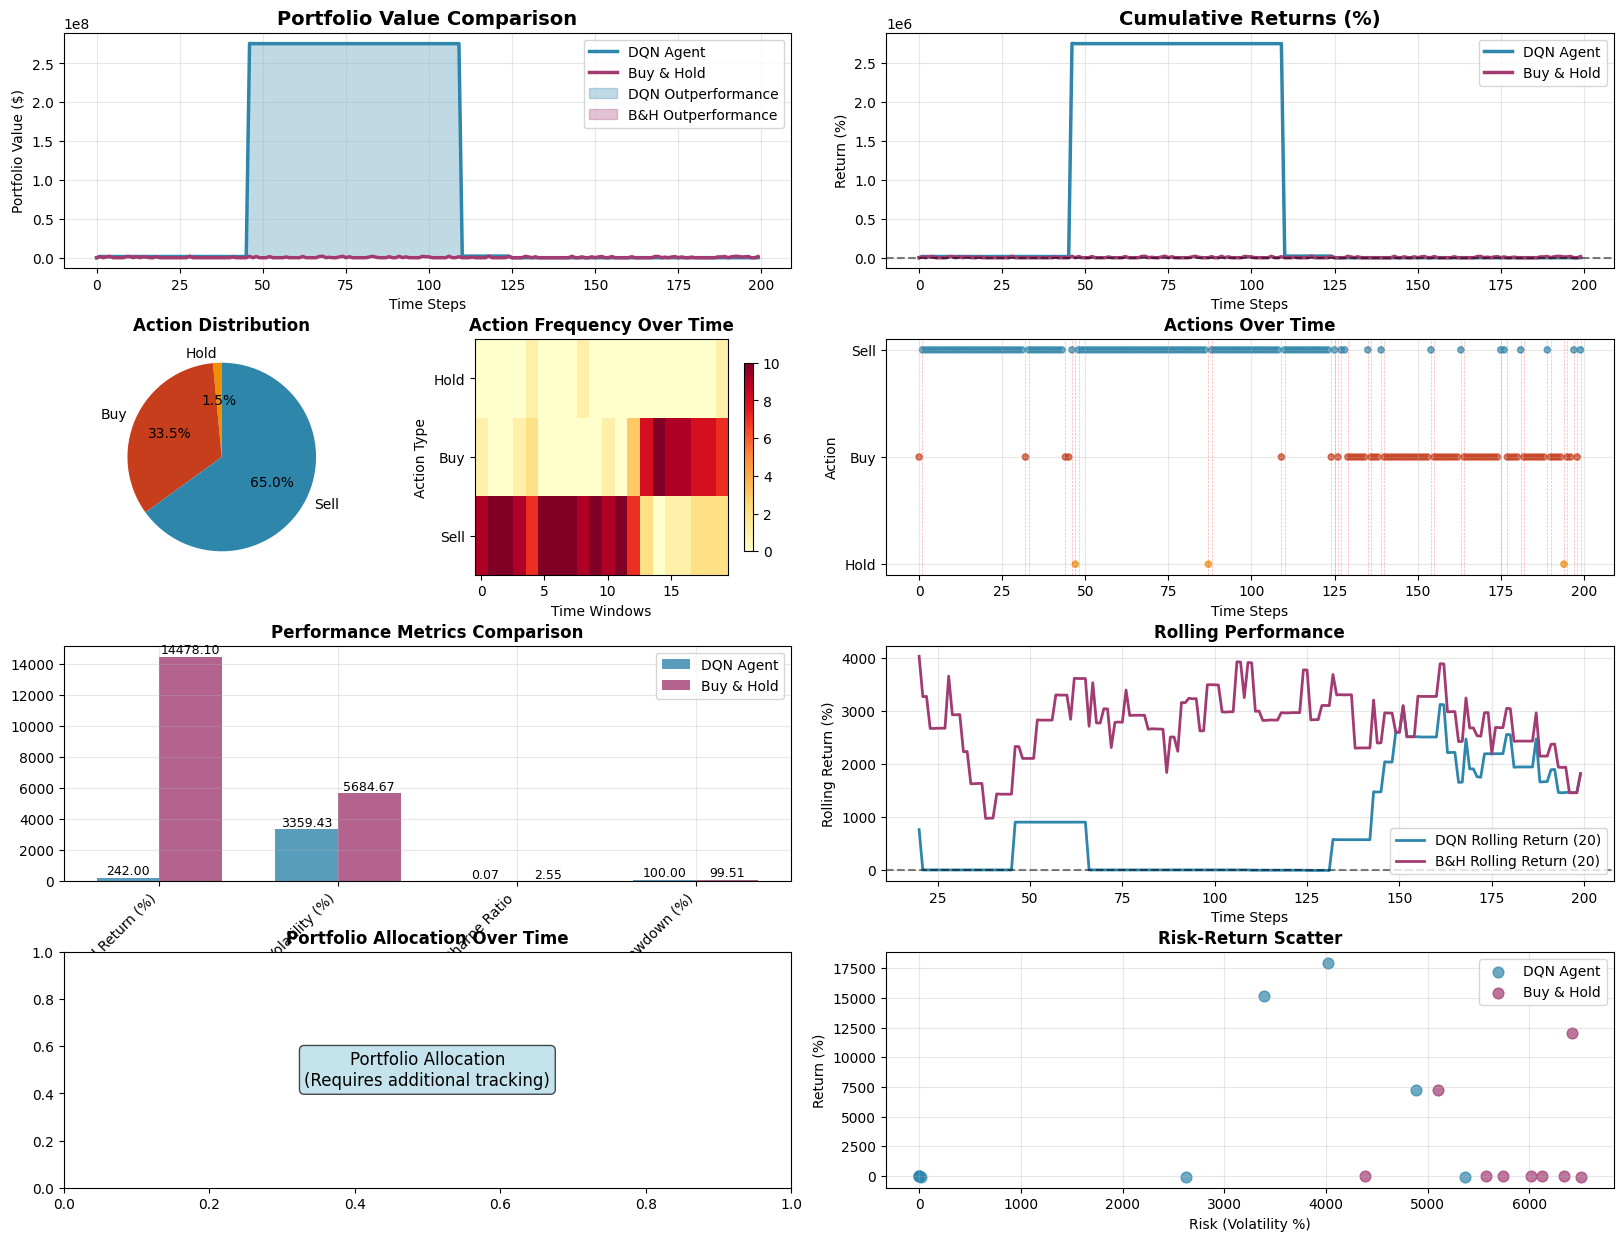


📊 COMPREHENSIVE PERFORMANCE ANALYSIS
💰 RETURNS:
   DQN Agent Return:       242.00%
   Buy & Hold Return:    14478.10%
   📈 Outperformance:    -14236.10%

💼 PORTFOLIO VALUES:
   Initial Value:        $10,000.00
   Final DQN Value:      $34,200.22
   Final B&H Value:      $1,457,809.78

📊 RISK METRICS:
   DQN Volatility:        3359.43%
   B&H Volatility:        5684.67%
   DQN Sharpe Ratio:         0.07
   B&H Sharpe Ratio:         2.55

🎯 TRADING ACTIVITY:
   Total Actions:        200
   Hold Actions:            3 (1.5%)
   Buy Actions:            67 (33.5%)
   Sell Actions:          130 (65.0%)
   Active Trading:        197 (98.5%)



In [67]:
plot_results(dqn_values, buy_hold_values, actions)

In [71]:
def calculate_max_drawdown(values):
    """Calculates the maximum drawdown from a list of values."""
    peak = -np.inf
    max_drawdown = 0
    for value in values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak if peak != 0 else 0
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown * 100 # Return as percentage

def plot_comprehensive_results(dqn_values, buy_hold_values, training_rewards, actions):
    """Plot comprehensive results with multiple metrics"""

    fig = plt.figure(figsize=(20, 15))

    # 1. Portfolio Value Comparison
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(dqn_values, label='DQN Agent', linewidth=2.5, color='#2E8B57')
    plt.plot(buy_hold_values, label='Buy & Hold', linewidth=2.5, color='#FF6347')
    plt.title('Portfolio Value Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Time Steps')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Training Progress
    ax2 = plt.subplot(2, 3, 2)
    plt.plot(training_rewards, alpha=0.6, color='lightblue')
    smoothed = pd.Series(training_rewards).rolling(50).mean()
    plt.plot(smoothed, color='darkblue', linewidth=2)
    plt.title('Training Rewards Over Episodes', fontsize=14, fontweight='bold')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, alpha=0.3)

    # 3. Action Distribution
    ax3 = plt.subplot(2, 3, 3)
    action_names = ['Hold', 'Buy', 'Sell']
    action_counts = [actions.count(i) for i in range(3)]
    colors = ['#FFD700', '#32CD32', '#FF4500']
    plt.pie(action_counts, labels=action_names, autopct='%1.1f%%', colors=colors)
    plt.title('Action Distribution', fontsize=14, fontweight='bold')

    # 4. Performance Metrics Bar Chart
    ax4 = plt.subplot(2, 3, 4)
    dqn_return = (dqn_values[-1] - dqn_values[0]) / dqn_values[0] * 100
    bh_return = (buy_hold_values[-1] - buy_hold_values[0]) / buy_hold_values[0] * 100

    metrics = ['Total Return (%)', 'Final Value ($)', 'Max Value ($)']
    dqn_metrics = [dqn_return, dqn_values[-1], max(dqn_values)]
    bh_metrics = [bh_return, buy_hold_values[-1], max(buy_hold_values)]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, dqn_metrics, width, label='DQN Agent', alpha=0.8, color='#2E8B57')
    plt.bar(x + width/2, bh_metrics, width, label='Buy & Hold', alpha=0.8, color='#FF6347')
    plt.title('Performance Metrics', fontsize=14, fontweight='bold')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Return Distribution
    ax5 = plt.subplot(2, 3, 5)
    dqn_returns = np.diff(dqn_values) / dqn_values[:-1]
    bh_returns = np.diff(buy_hold_values) / buy_hold_values[:-1]

    plt.hist(dqn_returns, bins=30, alpha=0.7, label='DQN Returns', density=True, color='#2E8B57')
    plt.hist(bh_returns, bins=30, alpha=0.7, label='Buy & Hold Returns', density=True, color='#FF6347')
    plt.title('Return Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Cumulative Returns
    ax6 = plt.subplot(2, 3, 6)
    dqn_cum_returns = np.cumprod(1 + dqn_returns) - 1
    bh_cum_returns = np.cumprod(1 + bh_returns) - 1

    plt.plot(dqn_cum_returns * 100, label='DQN Cumulative Returns', linewidth=2, color='#2E8B57')
    plt.plot(bh_cum_returns * 100, label='Buy & Hold Cumulative Returns', linewidth=2, color='#FF6347')
    plt.title('Cumulative Returns (%)', fontsize=14, fontweight='bold')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate and display metrics
    dqn_volatility = np.std(dqn_returns) * np.sqrt(252)  # Annualized
    bh_volatility = np.std(bh_returns) * np.sqrt(252)

    dqn_sharpe = (np.mean(dqn_returns) * 252) / dqn_volatility if dqn_volatility > 0 else 0
    bh_sharpe = (np.mean(bh_returns) * 252) / bh_volatility if bh_volatility > 0 else 0

    # Calculate additional metrics
    dqn_max_drawdown = calculate_max_drawdown(dqn_values)
    bh_max_drawdown = calculate_max_drawdown(buy_hold_values)

    # Calculate win rate for DQN
    positive_returns = sum(1 for r in dqn_returns if r > 0)
    win_rate = positive_returns / len(dqn_returns) * 100 if len(dqn_returns) > 0 else 0

    # Print comprehensive metrics summary
    print("\n" + "="*60)
    print("COMPREHENSIVE PERFORMANCE ANALYSIS")
    print("="*60)

    print(f"\n📊 PORTFOLIO PERFORMANCE:")
    print(f"{'Metric':<25} {'DQN Agent':<15} {'Buy & Hold':<15} {'Difference':<15}")
    print("-" * 70)
    print(f"{'Total Return (%)':<25} {dqn_return:<15.2f} {bh_return:<15.2f} {dqn_return - bh_return:<15.2f}")
    print(f"{'Final Value ($)':<25} {dqn_values[-1]:<15.2f} {buy_hold_values[-1]:<15.2f} {dqn_values[-1] - buy_hold_values[-1]:<15.2f}")
    print(f"{'Maximum Value ($)':<25} {max(dqn_values):<15.2f} {max(buy_hold_values):<15.2f} {max(dqn_values) - max(buy_hold_values):<15.2f}")

    print(f"\n📈 RISK METRICS:")
    print(f"{'Volatility (Annual %)':<25} {dqn_volatility*100:<15.2f} {bh_volatility*100:<15.2f} {(dqn_volatility-bh_volatility)*100:<15.2f}")
    print(f"{'Sharpe Ratio':<25} {dqn_sharpe:<15.2f} {bh_sharpe:<15.2f} {dqn_sharpe - bh_sharpe:<15.2f}")
    print(f"{'Max Drawdown (%)':<25} {dqn_max_drawdown:<15.2f} {bh_max_drawdown:<15.2f} {dqn_max_drawdown - bh_max_drawdown:<15.2f}")

    print(f"\n🎯 TRADING BEHAVIOR:")
    print(f"Win Rate (DQN): {win_rate:.1f}%")
    print(f"Total Actions: {len(actions)}")
    print(f"  - Hold: {action_counts[0]} ({action_counts[0]/len(actions)*100:.1f}%)")
    print(f"  - Buy:  {action_counts[1]} ({action_counts[1]/len(actions)*100:.1f}%)")
    print(f"  - Sell: {action_counts[2]} ({action_counts[2]/len(actions)*100:.1f}%)")

    print(f"\n🏆 SUMMARY:")
    if dqn_return > bh_return:
        outperformance = dqn_return - bh_return
        print(f"✅ DQN Agent OUTPERFORMED Buy & Hold by {outperformance:.2f}%")
    else:
        underperformance = bh_return - dqn_return
        print(f"❌ DQN Agent UNDERPERFORMED Buy & Hold by {underperformance:.2f}%")

    if dqn_sharpe > bh_sharpe:
        print(f"✅ DQN Agent achieved better risk-adjusted returns (Sharpe: {dqn_sharpe:.2f} vs {bh_sharpe:.2f})")
    else:
        print(f"❌ Buy & Hold achieved better risk-adjusted returns (Sharpe: {bh_sharpe:.2f} vs {dqn_sharpe:.2f})")

    print("="*60)

    return {
        'dqn_metrics': {
            'total_return': dqn_return,
            'final_value': dqn_values[-1],
            'max_value': max(dqn_values),
            'volatility': dqn_volatility,
            'sharpe_ratio': dqn_sharpe,
            'max_drawdown': dqn_max_drawdown,
            'win_rate': win_rate
        },
        'bh_metrics': {
            'total_return': bh_return,
            'final_value': buy_hold_values[-1],
            'max_value': max(buy_hold_values),
            'volatility': bh_volatility,
            'sharpe_ratio': bh_sharpe,
            'max_drawdown': bh_max_drawdown
        },
        'action_distribution': dict(zip(action_names, action_counts))
    }

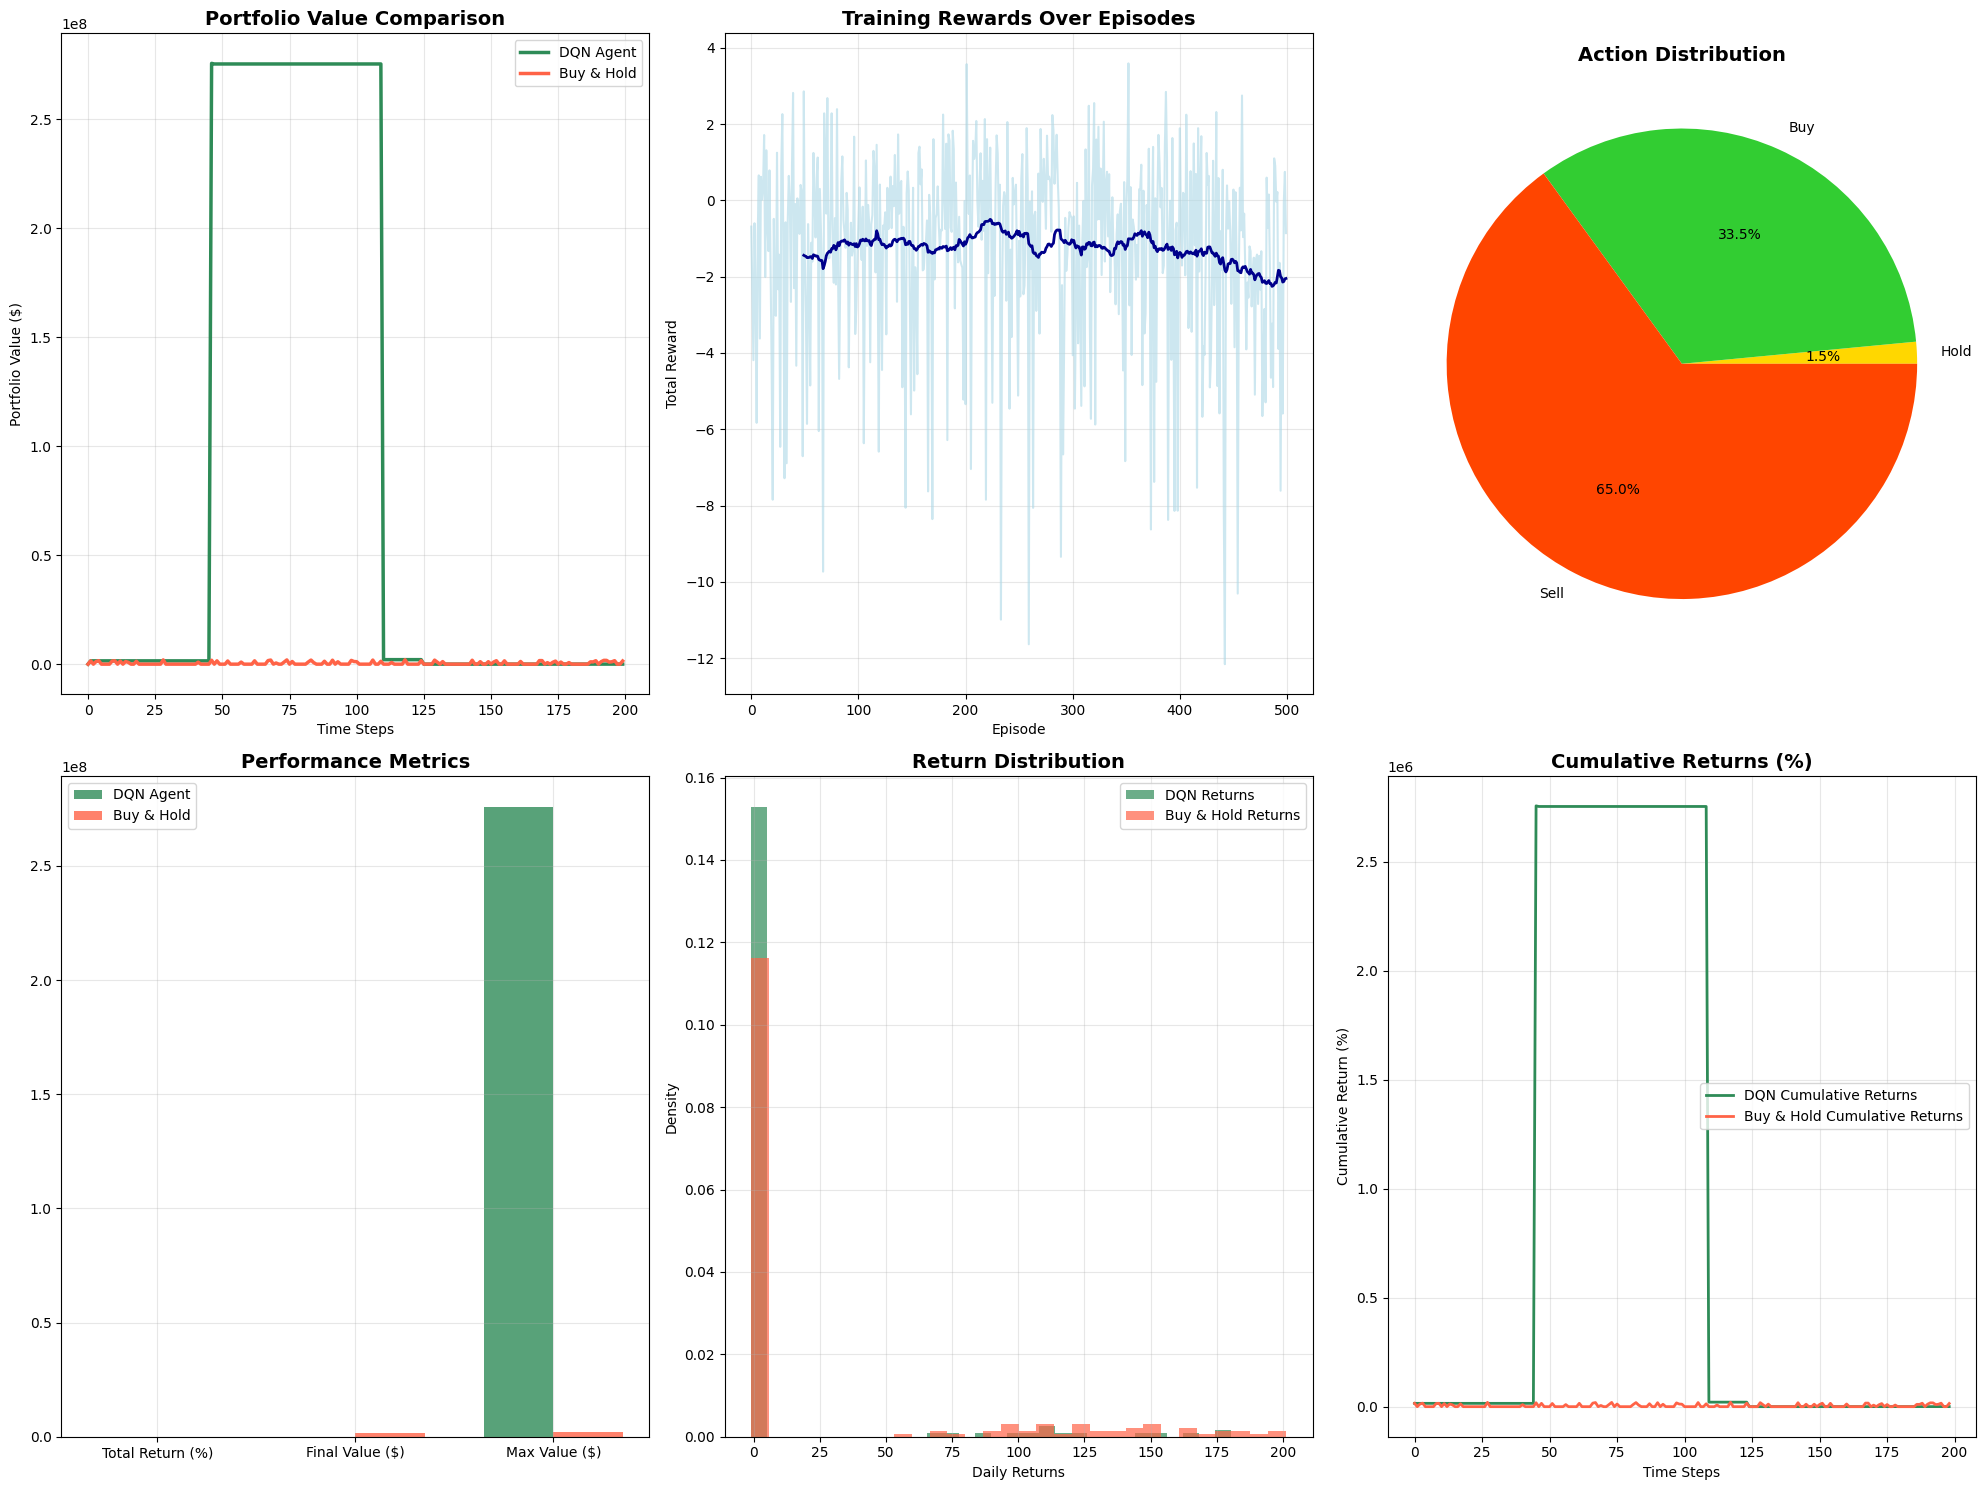


COMPREHENSIVE PERFORMANCE ANALYSIS

📊 PORTFOLIO PERFORMANCE:
Metric                    DQN Agent       Buy & Hold      Difference     
----------------------------------------------------------------------
Total Return (%)          242.00          14478.10        -14236.10      
Final Value ($)           34200.22        1457809.78      -1423609.56    
Maximum Value ($)         275671635.55    2022095.83      273649539.72   

📈 RISK METRICS:
Volatility (Annual %)     53329.34        90241.37        -36912.04      
Sharpe Ratio              4.32            7.88            -3.56          
Max Drawdown (%)          100.00          99.51           0.49           

🎯 TRADING BEHAVIOR:
Win Rate (DQN): 10.6%
Total Actions: 200
  - Hold: 3 (1.5%)
  - Buy:  67 (33.5%)
  - Sell: 130 (65.0%)

🏆 SUMMARY:
❌ DQN Agent UNDERPERFORMED Buy & Hold by 14236.10%
❌ Buy & Hold achieved better risk-adjusted returns (Sharpe: 7.88 vs 4.32)


{'dqn_metrics': {'total_return': np.float64(242.00221452036595),
  'final_value': np.float64(34200.221452036596),
  'max_value': np.float64(275671635.5497793),
  'volatility': np.float64(533.2933514568705),
  'sharpe_ratio': np.float64(4.320079762448606),
  'max_drawdown': np.float64(99.99999946301223),
  'win_rate': 10.552763819095476},
 'bh_metrics': {'total_return': np.float64(14478.097795694734),
  'final_value': np.float64(1457809.7795694734),
  'max_value': np.float64(2022095.8257793137),
  'volatility': np.float64(902.4137048372166),
  'sharpe_ratio': np.float64(7.879483356042193),
  'max_drawdown': np.float64(99.50546359512185)},
 'action_distribution': {'Hold': 3, 'Buy': 67, 'Sell': 130}}

In [72]:
plot_comprehensive_results(dqn_values , buy_hold_values , training_rewards , actions)